In [5]:
# importing some useful packages
from scipy.stats import linregress

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

In [6]:
# ROI

# Lane Finding Pipeline
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def stack_images(img_a, img_b):
    return np.hstack((img_a, img_b))

def show_image(img):
    plt.figure(figsize = (15, 10))
    plt.imshow(img)
    
def show_gray_image(img):
    plt.figure(figsize = (15, 10))
    plt.imshow(img, cmap='gray')
    
def plot_start():
    plt.figure(figsize = (15, 10))
    
def plot_lines(lines, color):
    for line in lines:
        for x1, y1, x2, y2 in line:
            plt.plot((x1, x2), (y1, y2), color)
        
def plot_function(f, xs):
    for x in range(xs[0], xs[len(xs) - 1]):
        plt.plot(x, f(x), 'g2')

In [7]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count # color image
    else:
        ignore_mask_color = 255 # grayscale
        
    #Depending on the image's dimensionality,
    #ignore_mask_color will be either a single intensity value (if the image is grayscale) or
    #a tuple of color values (if the image is color)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

# wrapper function 
def crop_roi(image, top_left, top_right, bottom_right, bottom_left):
    # roi is the list of vertices to call region_of_interest on
    # it defines four corner points of a quadrilateral region
    roi = [np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.int32)]
    return region_of_interest(image, roi)

# function to calculate the corner points of
# the quadrilateral region based on the reference parameters, and then call crop_roi to extract the region of interest
def crop_by_ref(img, ref_width, ref_height, ref_top_x, ref_top_y, ref_bot_x, ref_bot_y):
    width = img.shape[1]
    image_height = img.shape[0]
    middle_x = int(width / 2)
    image_offset_bottom_x = int(width * ref_bot_x / ref_width)
    image_offset_bottom_y = int(image_height * ref_bot_y / ref_height)
    image_offset_top_x = int(width * ref_top_x / ref_width)
    image_offset_top_y = int(image_height * ref_top_y / ref_height)
    top_left = [middle_x - image_offset_top_x, image_offset_top_y]
    top_right = [middle_x + image_offset_top_x, image_offset_top_y]
    bottom_right = [width - image_offset_bottom_x, image_offset_bottom_y]
    bottom_left = [image_offset_bottom_x, image_offset_bottom_y]

    return crop_roi(img, top_left, top_right, bottom_right, bottom_left)

# main func for cropping
# define reference parameters and then call crop_by_ref with these parameters to extract the region of interest.
def crop(image, bottom_offset = 0):
    ref_width = 960
    ref_height = 540
    ref_top_x = 50
    ref_top_y = 300
    ref_bottom_x = 70
    ref_bottom_y = 540 - bottom_offset

    return crop_by_ref(image, ref_width, ref_height, ref_top_x, ref_top_y, ref_bottom_x, ref_bottom_y)

In [8]:
# COLOR CORRECTION # 

def equalize_histogram(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def clache(img):
    # creates a Contrast Limited Adaptive Histogram Equalization (CLAHE),
    # limits the amplification of the contrast in flat regions of the image.
    cl = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (8, 8))
    
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(img_yuv)
    y_clache = cl.apply(y)
    img_yuv = cv2.merge((y_clache, u, v))
    
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR) 

def canny(img, low_threshold, high_threshold):
    # applies the Canny edge detection algorithm, used to find edges in images.
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    # gau.blur smoothing technique that helps reduce noise and detail in the image
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def biliteral(img):
    # Bilateral filtering preserves edges while reducing noise in the image.
    return cv2.bilateralFilter(img, 13, 75, 75)

def unsharp_mask(image, blured):
    # applies an unsharp mask operation, a sharpening tech., unsharp mask enhances edges and fine details in the image
    return cv2.addWeighted(blured, 1.5, blured, -0.5, 0, image)

In [9]:
# EDGE DETECTION #

def edges(img):
    # applies the Canny edge detector to detect edges in the image
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    v = np.median(gray_img)
    sigma = 0.33
    lower = int(max(150, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))

    return canny(gray_img, lower, upper)

In [10]:
# COLOR MASKING #

def binary_hsv_mask(img, color_range):
    lower = np.array(color_range[0])
    upper = np.array(color_range[1])
    # cv2.inRange() is used to create a binary mask where
    # pixel values within the specified range are set to 255 (white) and outside the range are set to 0 (black).
    return cv2.inRange(img, lower, upper)

# same func as above except,
# cv2.inRange() is applied only to the first channel (H) of the HSV image,
# effectively creating a binary mask based on the hue component.
def binary_gray_mask(img, color_range):
    lower = np.array(color_range[0])
    upper = np.array(color_range[1])

    return cv2.inRange(img, color_range[0][0], color_range[1][0])

def binary_mask_apply(img, binary_mask):
    masked_image = np.zeros_like(img)
    
    for i in range(3): 
        # copies the binary mask into all three channels (R, G, B) of the black image
        masked_image[:,:,i] = binary_mask.copy()
        
    return masked_image

def binary_mask_apply_color(img, binary_mask):
    return cv2.bitwise_and(img, img, mask = binary_mask)
    # The result is an image where pixels outside the mask are set to black, and pixels inside the mask retain their original color.

def filter_by_color_ranges(img, color_ranges):
    result = np.zeros_like(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    for color_range in color_ranges:
        color_bottom = color_range[0]
        color_top = color_range[1]
        
        # checks if the lower and upper bounds represent a grayscale color (where all three components are equal) or not.
        if color_bottom[0] == color_bottom[1] == color_bottom[2] and color_top[0] == color_top[1] == color_top[2]:
            mask = binary_gray_mask(gray_img, color_range)
        else:
            mask = binary_hsv_mask(hsv_img, color_range)
            
        masked_img = binary_mask_apply(img, mask)
        result = cv2.addWeighted(masked_img, 1.0, result, 1.0, 0.0)

    return result # result with all color ranges applied

# main func to filter an image for white and yellow colors
def color_threshold(img, white_value):
    # defines two color ranges: one for white and one for yellow.
    white = [[white_value, white_value, white_value], [255, 255, 255]]
    yellow = [[80, 90, 90], [120, 255, 255]]
    
    return filter_by_color_ranges(img, [white, yellow])

# "channels" refer to the different color components that make up a pixel's color in a particular color space. #


In [11]:
# function used for drawing lanes on an image
def draw_lanes(height, width, left_x, right_x, intersect_pt):
    line_img = np.zeros((height, width, 3), dtype=np.uint8)

    if left_x != 0 and intersect_pt != None:
        cv2.line(line_img, (left_x, height), (intersect_pt[0], intersect_pt[1]), [255, 0, 0], 5)
    if right_x != 0 and intersect_pt != None:
        cv2.line(line_img, (intersect_pt[0], intersect_pt[1]), (right_x, height), [0, 255, 0], 5)
        
    return line_img

In [12]:
# function is used to detect straight lines in an image using the probabilistic Hough Transform
def hough_lines(image, white_value):
    if white_value < 150:
        return None

    image_masked = color_threshold(image, white_value)
    image_edges = edges(image_masked)
    houghed_lns = cv2.HoughLinesP(image_edges, 2, np.pi / 180, 50, np.array([]), 20, 100)
    
    if houghed_lns is None:
        return hough_lines(image, white_value - 5)
    
    return houghed_lns

# func. identifying left and right lane lines in an image after detecting lines using the Hough Line Transform.
def left_right_lines(lines):
    lines_all_left = []
    lines_all_right = []
    slopes_left = []
    slopes_right = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            
            if slope > 0:
                lines_all_right.append(line)
                slopes_right.append(slope)
            else:
                lines_all_left.append(line)
                slopes_left.append(slope)
                
    filtered_left_lns = filter_lines_outliers(lines_all_left, slopes_left, True)
    filtered_right_lns = filter_lines_outliers(lines_all_right, slopes_right, False)
    
    return filtered_left_lns, filtered_right_lns

# func. responsible for filtering out outlier lines based on their slopes.
def filter_lines_outliers(lines, slopes, is_left, min_slope = 0.5, max_slope = 0.9):
    if len(lines) < 2:
        return lines
    
    lines_no_outliers = []
    slopes_no_outliers = []
    
    for i, line in enumerate(lines):
        slope = slopes[i]
        
        # condition checks if the absolute value of the slope falls within a specified range
        # filter out lines with slopes that fall outside of
        # the specified range (either too steep or too shallow) to be considered part of the lane lines
        if min_slope < abs(slope) < max_slope:
            lines_no_outliers.append(line)
            slopes_no_outliers.append(slope)

    slope_median = np.median(slopes_no_outliers)
    slope_std_deviation = np.std(slopes_no_outliers)
    filtered_lines = []
    
    for i, line in enumerate(lines_no_outliers):
        slope = slopes_no_outliers[i]
        intercepts = np.median(line)

        # This condition checks if the slope is within a certain range from the median slope. 
        # This is a more refined filter that takes into account the statistical properties of the slopes.
        if slope_median - 2 * slope_std_deviation < slope < slope_median + 2 * slope_std_deviation:
            filtered_lines.append(line)

    return filtered_lines


# This function is designed to calculate the median slope and intercept of a set of lines. 
def median(lines, prev_ms, prev_bs):
    if prev_ms is None:
        prev_ms = []
        prev_bs = []
    
    xs = []
    ys = []
    xs_med = []
    ys_med = []
    m = 0
    b = 0

    for line in lines:
        for x1, y1, x2, y2 in line:
            xs += [x1, x2]
            ys += [y1, y2]
    
    if len(xs) > 2 and len(ys) > 2:
#         m, b = np.polyfit(xs, ys, 1)
        m, b, r_value_left, p_value_left, std_err = linregress(xs, ys)

        if len(prev_ms) > 0:
            prev_ms.append(m)
            prev_bs.append(b)
        else:
            return np.poly1d([m, b])
    
    if len(prev_ms) > 0:
        return np.poly1d([np.average(prev_ms), np.average(prev_bs)])
    else:
        return None

# This function calculates the intersection point of two functions (f_a and f_b) at a specified bottom_y
def intersect(f_a, f_b, bottom_y):
    if f_a is None or f_b is None:
        return None
    
    equation = f_a.coeffs - f_b.coeffs
    x = -equation[1] / equation[0]
    y = np.poly1d(f_a.coeffs)(x)
    x, y = map(int, [x, y])

    return [x, y]

In [13]:
# finally detect and analyelane lines in images
def detect(image, white_value, prev_left_ms, prev_left_bs, prev_right_ms, prev_right_bs):
    houghed_lns = hough_lines(image, white_value)
    
    if houghed_lns is None:
        return [None, None, None, None]
    
    filtered_left_lns, filtered_right_lns = left_right_lines(houghed_lns)
    median_left_f = median(filtered_left_lns, prev_left_ms, prev_left_bs)
    median_right_f = median(filtered_right_lns, prev_right_ms, prev_right_bs)
    
    if median_left_f is None or median_right_f is None:
        return detect(image, white_value - 5, prev_left_ms, prev_left_bs, prev_right_ms, prev_right_bs)
    else:
        return [filtered_left_lns, filtered_right_lns, median_left_f, median_right_f]
    

In [14]:
def image_pipeline(image, prev_left_ms = [], prev_left_bs = [], prev_right_ms = [], 
                   prev_right_bs = [], bottom_offset = 0, should_plot = False):
    height = image.shape[0]
    width = image.shape[1]
    
    image_cropped = crop(image, bottom_offset)
    image_blured = biliteral(image_cropped)
    image_unsharp = unsharp_mask(image_cropped, image_blured)
    image_clached = clache(image_unsharp)

    #----------------------------- HOUGH ---------------------------
    left_lns, right_lns, median_left_f, median_right_f = detect(
        image_clached, 220, prev_left_ms, prev_left_bs, prev_right_ms, prev_right_bs)
    
    if median_left_f is None and median_right_f is None:
        return [image, None, None]
    
    intersect_pt = intersect(median_left_f, median_right_f, height)
    
    if intersect_pt is None:
        return [image, median_left_f, median_right_f]
    
    left_x = int((median_left_f - height).roots)
    right_x = int((median_right_f - height).roots)
    
    #----------------------------- DRAW ---------------------------
    
    if should_plot:
        plot_start()
        plot_lines(left_lns, 'r')
        plot_lines(right_lns, 'b')
    
        if median_left_f is not None:
            plot_function(median_left_f, [left_x, intersect_pt[0]])
        
        if median_right_f is not None:
            plot_function(median_right_f, [intersect_pt[0], right_x])
            
    lanes = draw_lanes(height, width, left_x, right_x, intersect_pt)
    return [weighted_img(lanes, image), median_left_f, median_right_f]


In [15]:
os.listdir("test_images/")

['challenge1.jpg',
 'challenge2.jpg',
 'challenge3.jpg',
 'challenge4.jpg',
 'challenge5.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg',
 'whiteCarLaneSwitch.jpg']

C:\Users\Affaan\AppData\Local\Temp\ipykernel_10484\1858812976.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  left_x = int((median_left_f - height).roots)
C:\Users\Affaan\AppData\Local\Temp\ipykernel_10484\1858812976.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  right_x = int((median_right_f - height).roots)


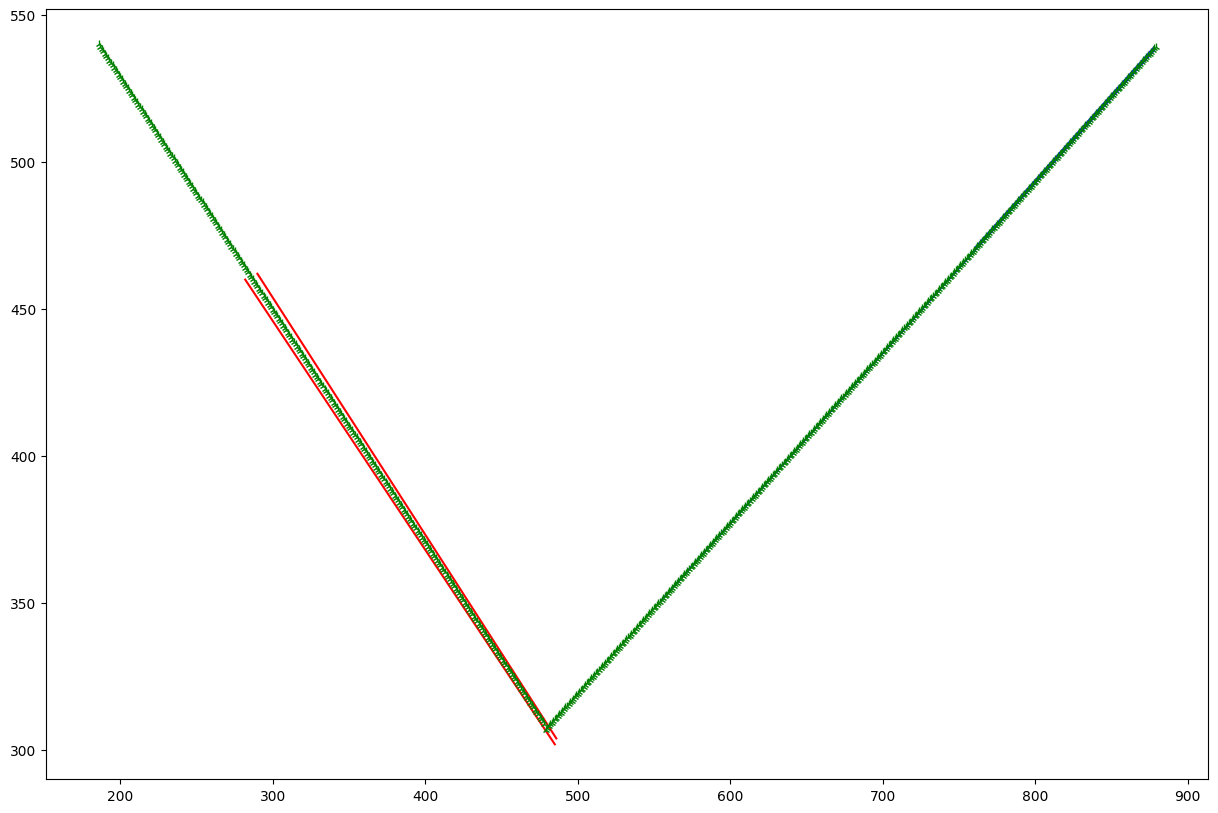

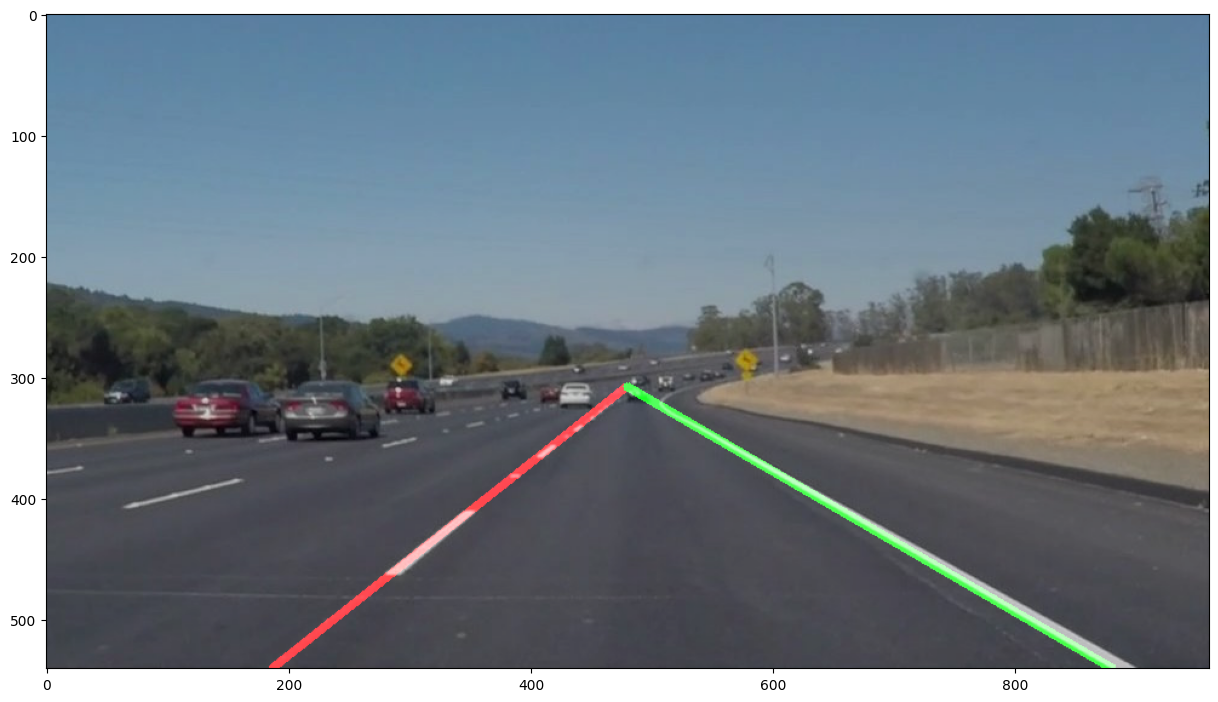

In [19]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image, left_f, right_f = image_pipeline(image, should_plot = True)
show_image(image)

In [20]:
for img in os.listdir('test_images/'):
    if img.endswith('jpg'):
        image = mpimg.imread('test_images/{}'.format(img))
        image, left_f, right_f = image_pipeline(image, [], [], [], [])
        
        plt.figure(figsize = (15, 10))
        mpimg.imsave('test_images_output/{}'.format(img), image)

C:\Users\Affaan\AppData\Local\Temp\ipykernel_10484\1858812976.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  left_x = int((median_left_f - height).roots)
C:\Users\Affaan\AppData\Local\Temp\ipykernel_10484\1858812976.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  right_x = int((median_right_f - height).roots)


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>